In [ ]:
# Installation and setting of the required drivers
# Web drivers allow the automation of interactions in a web browser.

%%shell
# Ubuntu no longer distributes chromium-browser outside of snap
# Proposed solution: https://askubuntu.com/questions/1204571/how-to-install-chromium-without-snap

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chrome and chrome-driver
# It would be better to install chromium, as it is faster. However, as Chromium doesn't have webgl enabled, Chrome version 112 is needed.
apt-get update
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
sudo dpkg -i google-chrome-stable_current_amd64.deb
mkdir /content/drivers && cd /content/drivers && wget https://chromedriver.storage.googleapis.com/112.0.5615.49/chromedriver_linux64.zip && unzip chromedriver_linux64.zip && rm -rf *.zip*
chmod +x /content/drivers/chromedriver

# Install selenium
pip install selenium

Executing: /tmp/apt-key-gpghome.lZFlUp8ZGL/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
gpg: key DCC9EFBF77E11517: public key "Debian Stable Release Key (10/buster) <debian-release@lists.debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.sHkFTxcKSh/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
gpg: key DC30D7C23CBBABEE: public key "Debian Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Executing: /tmp/apt-key-gpghome.bVqIVuVxZb/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A
gpg: key 4DFAB270CAA96DFA: public key "Debian Security Archive Automatic Signing Key (10/buster) <ftpmaster@debian.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 https://cloud.r-project.org/bin/l

In [ ]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 103.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


In [ ]:
# Connecting with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Selenium is a web driver wrapper
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

# to check for alerts:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException

# some essential python libraries to make it chooch
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import random
import time

In [ ]:
import shutil

"""
# creation of a new folder to store the downloads
try:
  download_folder = "/content/drive/MyDrive/TFG/database"
  os.makedirs(download_folder)

except FileExistsError:
  print("This folder already exsists!")
  pass
"""

In [ ]:
# DECLARATION OF CONSTANTS
LAT_MIN = -84 # The web only convers a latitude between -84 and 84
LAT_MAX = 84
LON_MIN = -180
LON_MAX = 180

In [ ]:
def draw_map():
    # returns world_map: a Basemap object that contains the entire world, useful to know if a coordinaate is on land.
    gridsize = 0.1
    world_map = Basemap(projection="merc", resolution = 'c', area_thresh = 0.1,llcrnrlon=LON_MIN, llcrnrlat=LAT_MIN, urcrnrlon=LON_MAX, urcrnrlat=LAT_MAX)
    world_map.drawcoastlines(color='black')
    return world_map

map is drawn
imagen  0
map_lon152.54_lat-26.27


/content/drive/MyDrive/TFG/database/hmap_152_-26__0.png
imagen  1
map_lon-63.95_lat4.87


/content/drive/MyDrive/TFG/database/hmap_-63_4__0.png
imagen  2
map_lon77.54_lat48.78


/content/drive/MyDrive/TFG/database/hmap_77_48__0.png
imagen  3
map_lon141.75_lat43.34


/content/drive/MyDrive/TFG/database/hmap_141_43__1.png
imagen  4
map_lon-90.31_lat35.62


/content/drive/MyDrive/TFG/database/hmap_-90_35__0.png
imagen  5
map_lon-108.84_lat50.16


/content/drive/MyDrive/TFG/database/hmap_-108_50__0.png
imagen  6
map_lon86.42_lat36.20


/content/drive/MyDrive/TFG/database/hmap_86_36__1.png
imagen  7
map_lon162.04_lat55.84


/content/drive/MyDrive/TFG/database/hmap_162_55__0.png
imagen  8
map_lon123.68_lat69.43


/content/drive/MyDrive/TFG/database/hmap_123_69__1.png
imagen  9
map_lon36.21_lat47.90


/content/drive/MyDrive/TFG/database/hmap_36_47__0.png
imagen  10
map_lon11.02_lat14.86


/content/drive/MyDrive/TFG/database/hmap_11_14__0.png
im

KeyboardInterrupt: ignored

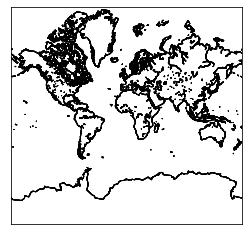

In [ ]:
# Chrome seems to be slower than chromium, then we must assure that the actions have had enough time to be done correctly after passing to 
# the next action. The function save_action waits a random time, which can be configured through min_time and max_time. Then, if the action 
# hasn't ended yet and therefore the element isn't visible, it has a "patience" time. Having passed this time (at the moment is 10s), the 
# system considers that there has been an error and takes a screenshot which is supposed to help you finding it.

def safe_action(driver, element, action=lambda x: x.click(), min_time=0, max_time=3):
  time.sleep(random.uniform(min_time, max_time))
  seconds = 0
  patience = 10
  while not element.is_displayed() and seconds < patience:
    time.sleep(1)
    seconds += 1
  if seconds >= patience:
    print(element.source)
    driver.get_screenshot_as_file("error.png")
  action(element)


def main():
    # instantiate a chrome options object so you can set the size and headless preference
    options = webdriver.ChromeOptions()
    options.add_argument("--no-sandbox")
    options.add_argument("--window-size=1920x1080")
    options.add_argument('--headless')
    options.add_argument("--start-maximized")

    options.add_argument("--disable-dev-shm-usage")
    options.add_experimental_option('excludeSwitches', ['enable-logging'])
    prefs = {"profile.default_content_settings.popups": 0,    
        "download.default_directory":r"/content/downloads/", ### Set the path accordingly
        "download.prompt_for_download": False, ## change the downpath accordingly
        "download.directory_upgrade": True}
    options.add_experimental_option("prefs", prefs)

    # Service and Options changed to satisfy chrome and not chromium
    driver = webdriver.Chrome(service=Service("/content/drivers/chromedriver"), options=options)

    # navigate to the page you want to acquire data from
    driver.get("https://heightmap.skydark.pl/")

    # Offers to try the beta version --> we just have to acccept
    beta_alert = driver.switch_to.alert.accept()

    # capture the screen in case of error
    #driver.get_screenshot_as_file("capture.png")

    # description of all the buttons that can be pushed
    info_button = driver.find_element(By.CSS_SELECTOR, "[title=Settings]")
    search_coord_button = driver.find_element(By.CSS_SELECTOR, "a[title='Set lng/lat']")
    save_png_button = driver.find_element(By.CSS_SELECTOR, "a[title='Download PNG height map']")
    refresh_button = driver.find_element(By.CSS_SELECTOR, "button[onclick='getHeightmap(2)']")
    auto_button = driver.find_element(By.CSS_SELECTOR, "button[onclick='autoSettings()']")
    clear_button = driver.find_element(By.CSS_SELECTOR, "button[onclick='setLngLat(1)']")
    apply_coord = driver.find_element(By.CSS_SELECTOR, "button[onclick='setLngLat(2)']")

    # instantiate map object
    world_map=draw_map()
    print("map is drawn")

    for i in range(31):
        # Refresh the page each 30 iterations so it doesn't get stuck
        if(i%30 == 0 and i != 0):
            main()

        print("imagen ", i)
        while True:
            # # generate a random point that is on land
            lon, lat = random.uniform(LON_MIN,LON_MAX), random.uniform(LAT_MIN, LAT_MAX)
            xpt, ypt = world_map( lon, lat ) # convert to projection map

            # Check if that point is on the map
            if world_map.is_land(xpt,ypt):
                # if it is on the map, print the name and break
                name="map_lon{:4.2f}_lat{:4.2f}".format(lon, lat) # note that the precision can be changed here.
                print(name)
                print("\n")
                break

        # click the location button on heightmap.skydark.pl
        safe_action(driver, search_coord_button)
        # clear the coordinates field
        safe_action(driver, clear_button)
        # enter gps coordinate string of land coordinates
        safe_action(driver, driver.find_element(By.ID, 'lngInput'), action=lambda x: x.send_keys("{}".format(lon)))
        # enter gps coordinate string of land coordinates
        safe_action(driver, driver.find_element(By.ID, 'latInput'), action=lambda x: x.send_keys("{}".format(lat)), max_time=0)

        # click apply
        safe_action(driver, apply_coord)

        # fix parameters
        safe_action(driver, info_button)

        # click the auto button to determine directly the height scale and the base level
        safe_action(driver, refresh_button)
        safe_action(driver, auto_button)


        # save the data to a png file by clicking the save button
        safe_action(driver, save_png_button, min_time=3, max_time=5)
        time.sleep(random.uniform(3, 5)) # download time is what may cause delay in this script

        # Wait more if file is not downloaded
        seconds_passed = 0
        while not os.path.isfile("/content/heightmap.png") and seconds_passed < 90:
            time.sleep(2)
            seconds_passed += 2

        if os.path.isfile("/content/heightmap.png"):

            # Move file to downloads folder without overriding any other file
            filename_template = "/content/drive/MyDrive/TFG/database/hmap_%s_%s__%s.png"
            tries = 0
            while os.path.isfile(filename_template % (int(lon), int(lat), tries)):
              tries += 1
            shutil.move("/content/heightmap.png", filename_template % (int(lon), int(lat), tries))
            print(filename_template % (int(lon), int(lat), tries))

    driver.quit()

if __name__=="__main__":
    main()

In [ ]:
# Create a zip from the download folder and download it to your pc
!zip -r /content/file.zip /content/drive/MyDrive/TFG/database

from google.colab import files
files.download("/content/file.zip")

  adding: content/drive/MyDrive/TFG/database/ (stored 0%)
  adding: content/drive/MyDrive/TFG/database/hmap_-122_51__0.png (deflated 21%)
  adding: content/drive/MyDrive/TFG/database/hmap_32_-7__0.png (deflated 29%)
  adding: content/drive/MyDrive/TFG/database/hmap_125_-8__0.png (deflated 56%)
  adding: content/drive/MyDrive/TFG/database/hmap_171_63__0.png (deflated 39%)
  adding: content/drive/MyDrive/TFG/database/hmap_29_39__0.png (deflated 24%)
  adding: content/drive/MyDrive/TFG/database/hmap_-82_71__0.png (deflated 44%)
  adding: content/drive/MyDrive/TFG/database/hmap_94_80__0.png (deflated 74%)
  adding: content/drive/MyDrive/TFG/database/hmap_93_20__0.png (deflated 12%)
  adding: content/drive/MyDrive/TFG/database/hmap_92_21__0.png (deflated 5%)
  adding: content/drive/MyDrive/TFG/database/hmap_104_57__0.png (deflated 39%)
  adding: content/drive/MyDrive/TFG/database/hmap_115_61__0.png (deflated 97%)
  adding: content/drive/MyDrive/TFG/database/hmap_-106_45__0.png (deflated 39%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>